# PVDiagnostics Assignment :-  Domain Research with Data Analytics 

### By:- Junaid Nasir Khan (junaidkhangec@gmail.com)

## 1. Data Scraping

In [31]:
# required imports 
from selenium import webdriver
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [115]:
url = "https://www.iexindia.com/marketdata/areaprice.aspx"
# create a new Edge session
driver = webdriver.Edge(executable_path='msedgedriver.exe')
driver.implicitly_wait(30)
driver.get(url)

In [116]:
# finding elements 
driver.find_element_by_xpath("//select[@name='ctl00$InnerContent$ddlInterval']/option[text()='15-Minute Block']").click()
driver.find_element_by_xpath("//select[@name='ctl00$InnerContent$ddlPeriod']/option[text()='Last 8 Days']").click()
driver.find_element_by_name('ctl00$InnerContent$btnUpdateReport').click()

In [117]:
# to process 1 page
def one_page_scrape(rows):
    temp_list = []
    for i,row in enumerate(rows[2:]):
        current_row = row.text.split('\n')
        if i == 0:
            current_date = current_row[0]
            current_hour = current_row[1]
            temp_list.append(current_row)
            continue
        elif i%4 == 0:
            current_hour = current_row[0]
            current_row.insert(0,current_date)
            temp_list.append(current_row)
            continue
        else:
            current_row.insert(0,current_hour)
            current_row.insert(0,current_date)
            temp_list.append(current_row)
    df = pd.DataFrame(data=temp_list,columns=['Date','Hour','Time Block','A1','A2','E1','E2','N1','N2','N3','S1','S2','S3','W1','W2','W3','MCP'])
    return df

In [118]:
# dataframe to hold whole data
df = pd.DataFrame(data=temp_list,columns=['Date','Hour','Time Block','A1','A2','E1','E2','N1','N2','N3','S1','S2','S3','W1','W2','W3','MCP'])

# iterating over all pages (pagination)
for i in range(7):
    table = driver.find_element_by_css_selector("table[style='border-collapse:collapse;']")
    rows = table.find_elements_by_tag_name('tr')
    one_day_df = one_page_scrape(rows)
    df = pd.concat([df,one_day_df],ignore_index=True )
    driver.find_element_by_name('ctl00$InnerContent$reportViewer$ctl05$ctl00$Next$ctl00$ctl00').click()
    driver.implicitly_wait(30)

# closing driver connection
driver.close()

# formating datatypes of final dataframe
col_type = {'Hour':int,'A1':float,'A2':float,'E1':float,'E2':float,'N1':float,'N2':float,'N3':float,'S1':float,'S2':float,'S3':float,'W1':float,'W2':float,'W3':float,'MCP':float}
df = df.astype(col_type)
df['Date'] = df['Date'].astype('datetime64[ns]')
df.sort_values(by=['Date','Hour'],inplace=True,ignore_index=True)

In [120]:
# saveing to csv
df.to_csv('dam_area_prices.csv',index=False)

## 2. Plotting Data

In [3]:
# reading data
df = pd.read_csv('dam_area_prices.csv')

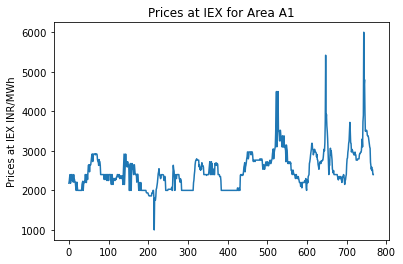

In [11]:
df['A1'].plot(ylabel='Prices at IEX INR/MWh',title='Prices at IEX for Area A1',kind='line')
plt.show()

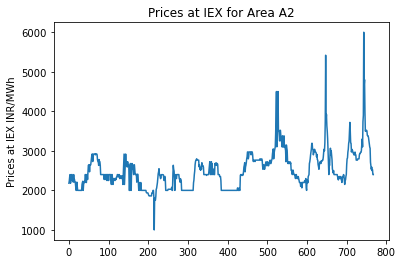

In [12]:
df['A2'].plot(ylabel='Prices at IEX INR/MWh',title='Prices at IEX for Area A2',kind='line')
plt.show()

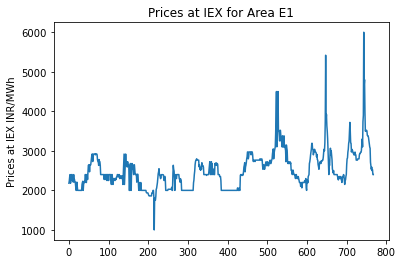

In [13]:
df['E1'].plot(ylabel='Prices at IEX INR/MWh',title='Prices at IEX for Area E1',kind='line')
plt.show()

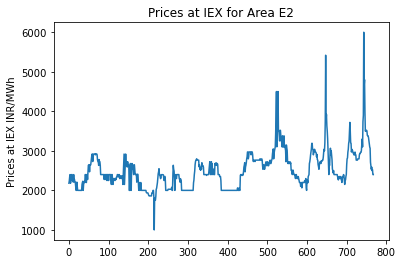

In [14]:
df['E2'].plot(ylabel='Prices at IEX INR/MWh',title='Prices at IEX for Area E2',kind='line')
plt.show()

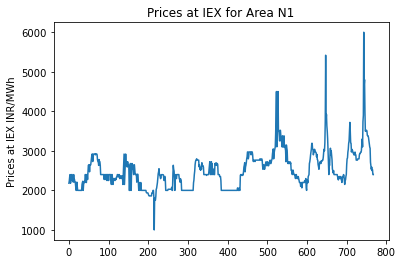

In [15]:
df['N1'].plot(ylabel='Prices at IEX INR/MWh',title='Prices at IEX for Area N1',kind='line')
plt.show()

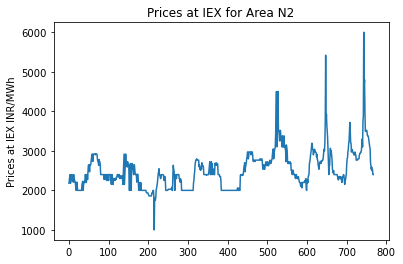

In [16]:
df['N2'].plot(ylabel='Prices at IEX INR/MWh',title='Prices at IEX for Area N2',kind='line')
plt.show()

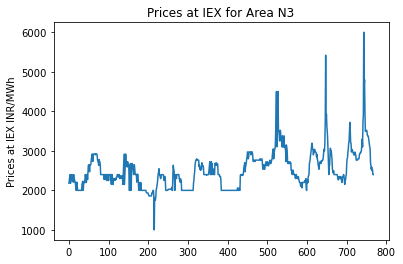

In [17]:
df['N3'].plot(ylabel='Prices at IEX INR/MWh',title='Prices at IEX for Area N3',kind='line')
plt.show()

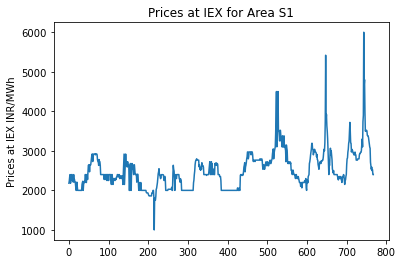

In [18]:
df['S1'].plot(ylabel='Prices at IEX INR/MWh',title='Prices at IEX for Area S1',kind='line')
plt.show()

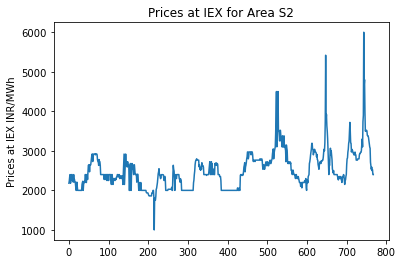

In [19]:
df['S2'].plot(ylabel='Prices at IEX INR/MWh',title='Prices at IEX for Area S2',kind='line')
plt.show()

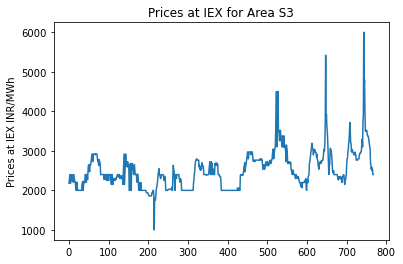

In [20]:
df['S3'].plot(ylabel='Prices at IEX INR/MWh',title='Prices at IEX for Area S3',kind='line')
plt.show()

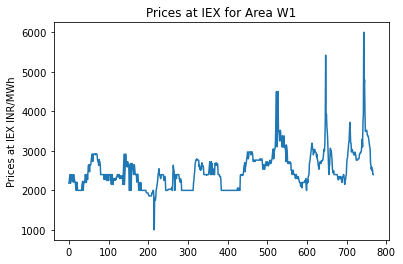

In [21]:
df['W1'].plot(ylabel='Prices at IEX INR/MWh',title='Prices at IEX for Area W1',kind='line')
plt.show()

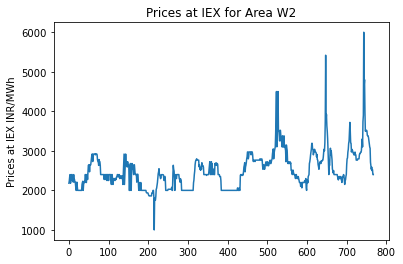

In [22]:
df['W2'].plot(ylabel='Prices at IEX INR/MWh',title='Prices at IEX for Area W2',kind='line')
plt.show()

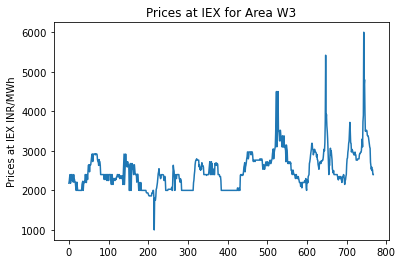

In [23]:
df['W3'].plot(ylabel='Prices at IEX INR/MWh',title='Prices at IEX for Area W3',kind='line')
plt.show()

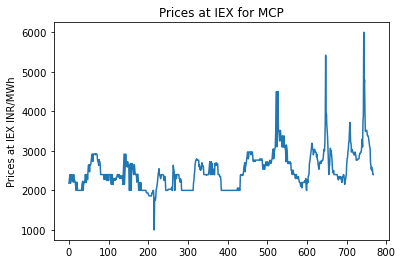

In [24]:
df['MCP'].plot(ylabel='Prices at IEX INR/MWh',title='Prices at IEX for MCP',kind='line')
plt.show()

## 3. Fitting Moving Average for feature 'A1' (Univariate)

In [42]:
uni_data = df.A1.values

In [43]:
TRAIN_SPLIT = 700 # First 700 obs will be used as train data and rest as test data.

# Normalize data: mean centering and variance-scaling.
# NOTE: use only train data to normalize all of the data. otherwise, leakage-issue 
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

uni_data = (uni_data-uni_train_mean)/uni_train_std
print(type(uni_data))

<class 'numpy.ndarray'>


In [44]:
# gunction to formate data
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
        # Reshape data from (history_size,) to (history_size, 1)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i+target_size])
    return np.array(data), np.array(labels)

In [32]:
# use the above function to create the datasets.
univariate_past_history = 10 
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

print(x_train_uni.shape)
print(y_train_uni.shape)
print(x_val_uni.shape)
print(y_val_uni.shape)

(690, 10, 1)
(690,)
(58, 10, 1)
(58,)


In [46]:
x_train_uni[0]

array([[-0.66676281],
       [-0.51420413],
       [-0.25447634],
       [-0.13367328],
       [-0.66676281],
       [-0.51420413],
       [-0.25447634],
       [-0.13367328],
       [-0.1343562 ],
       [-0.49920436]])

In [47]:
y_train_uni[0]

-0.4385223478167641

In [48]:
#utility function
def create_time_steps(length):
    return list(range(-length, 0))

print(create_time_steps(10))

[-10, -9, -8, -7, -6, -5, -4, -3, -2, -1]


In [49]:
# to calculate moving averages
def mwa(history):
    return np.mean(history)

In [50]:
# Plotting function

# plot_data: contains labels as list
# delta: 0 => next time step given last "k" steps.
# title: plot title

# Usage: show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go'] # dot-line, red-x, green-o  refer: https://matplotlib.org/3.1.1/api/markers_api.html
    time_steps = create_time_steps(plot_data[0].shape[0])
  
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    return plt

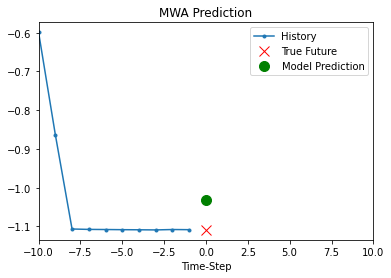

In [53]:
i=20 # index value
show_plot([x_train_uni[i], y_train_uni[i], mwa(x_train_uni[i])], 0,
           'MWA Prediction')
plt.show()

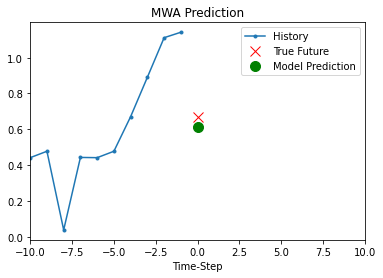

In [52]:
i=50 # index value
show_plot([x_train_uni[i], y_train_uni[i], mwa(x_train_uni[i])], 0,
           'MWA Prediction')
plt.show()